In [1]:
import numpy as np
import cv2, os, pyautogui, time
from PIL import Image
import matplotlib.pyplot as plt
import warnings

from src.face_features import *
from src.tools import *

width, height= pyautogui.size()

In [ ]:
# pickle.dump([X_left, X_right, X_face, X_mask, Y], open("save.pkl", "wb"))

# X_left = np.concatenate([X_left, X_left_old])
# X_right = np.concatenate([X_right, X_right_old])
# X_face = np.concatenate([X_face, X_face_old])
# X_mask = np.concatenate([X_mask, X_mask_old])
# Y = np.concatenate([Y, Y_old])

In [ ]:
X_left_old, X_right_old, X_face_old, X_mask_old, Y_old = X_left, X_right, X_face, X_mask, Y

In [3]:
import pickle

[X_left, X_right, X_face, X_mask, Y] = pickle.load(open("save.pkl", "rb"))
print(X_left.shape, X_right.shape, X_face.shape, X_mask.shape, Y.shape)

(5100, 32, 64, 1) (5100, 32, 64, 1) (5100, 64, 64, 1) (5100, 64, 64, 1) (5100, 2)


In [4]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(list(range(len(Y))), train_size=0.9, shuffle=True)

X_train = [X_left[train_set], X_right[train_set], X_face[train_set], X_mask[train_set]]
X_test = [X_left[test_set], X_right[test_set], X_face[test_set], X_mask[test_set]]

In [4]:
from keras.models import load_model
model = load_model("checkpoints")

In [8]:
history = model.fit(X_train, np.array(Y)[train_set], batch_size=256, epochs=200, validation_data=(X_test, np.array(Y)[test_set]))

Epoch 1/200
18/18 [==============================] - 1s 79ms/step - loss: 0.0432 - val_loss: 0.0223
Epoch 2/200
18/18 [==============================] - 1s 58ms/step - loss: 0.0182 - val_loss: 0.0120
Epoch 3/200
18/18 [==============================] - 1s 58ms/step - loss: 0.0123 - val_loss: 0.0111
Epoch 4/200
18/18 [==============================] - 1s 58ms/step - loss: 0.0099 - val_loss: 0.0079
Epoch 5/200
18/18 [==============================] - 1s 58ms/step - loss: 0.0086 - val_loss: 0.0077
Epoch 6/200
18/18 [==============================] - 1s 59ms/step - loss: 0.0075 - val_loss: 0.0078
Epoch 7/200
18/18 [==============================] - 1s 57ms/step - loss: 0.0067 - val_loss: 0.0069
Epoch 8/200
18/18 [==============================] - 1s 58ms/step - loss: 0.0055 - val_loss: 0.0062
Epoch 9/200
18/18 [==============================] - 1s 57ms/step - loss: 0.0056 - val_loss: 0.0048
Epoch 10/200
18/18 [==============================] - 1s 61ms/step - loss: 0.0048 - val_loss: 0.0065

18/18 [==============================] - 1s 59ms/step - loss: 2.5848e-04 - val_loss: 5.6715e-04
Epoch 80/200
18/18 [==============================] - 1s 61ms/step - loss: 2.3857e-04 - val_loss: 4.8343e-04
Epoch 81/200
18/18 [==============================] - 2s 102ms/step - loss: 2.4268e-04 - val_loss: 5.3864e-04
Epoch 82/200
18/18 [==============================] - 5s 260ms/step - loss: 2.6505e-04 - val_loss: 5.1448e-04
Epoch 83/200
18/18 [==============================] - 3s 180ms/step - loss: 2.5901e-04 - val_loss: 4.8207e-04
Epoch 84/200
18/18 [==============================] - 5s 300ms/step - loss: 2.4526e-04 - val_loss: 6.0988e-04
Epoch 85/200
18/18 [==============================] - 4s 222ms/step - loss: 3.8549e-04 - val_loss: 7.4484e-04
Epoch 86/200
18/18 [==============================] - 4s 240ms/step - loss: 2.6229e-04 - val_loss: 4.5456e-04
Epoch 87/200
18/18 [==============================] - 3s 193ms/step - loss: 1.9997e-04 - val_loss: 4.6399e-04
Epoch 88/200
18/18 [=====

18/18 [==============================] - 4s 205ms/step - loss: 2.1281e-04 - val_loss: 3.9466e-04
Epoch 154/200
18/18 [==============================] - 4s 210ms/step - loss: 1.1718e-04 - val_loss: 3.8643e-04
Epoch 155/200
18/18 [==============================] - 3s 145ms/step - loss: 9.7301e-05 - val_loss: 3.2716e-04
Epoch 156/200
18/18 [==============================] - 6s 351ms/step - loss: 1.1468e-04 - val_loss: 3.3906e-04
Epoch 157/200
18/18 [==============================] - 4s 213ms/step - loss: 1.3257e-04 - val_loss: 4.6041e-04
Epoch 158/200
18/18 [==============================] - 3s 187ms/step - loss: 1.8223e-04 - val_loss: 3.6020e-04
Epoch 159/200
18/18 [==============================] - 4s 234ms/step - loss: 1.3594e-04 - val_loss: 3.0891e-04
Epoch 160/200
18/18 [==============================] - 4s 238ms/step - loss: 8.6872e-05 - val_loss: 2.9939e-04
Epoch 161/200
18/18 [==============================] - 4s 248ms/step - loss: 9.0712e-05 - val_loss: 3.0623e-04
Epoch 162/200
1

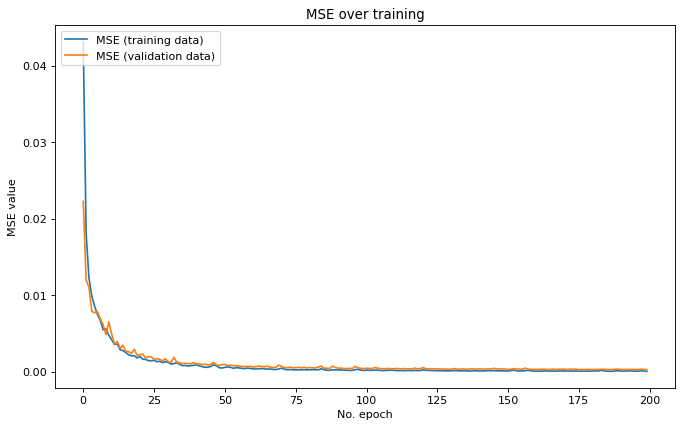

In [9]:
# Plot history: MAE
plt.figure(figsize=(10,6), dpi=80)
plt.plot(history.history['loss'], label='MSE (training data)')
plt.plot(history.history['val_loss'], label='MSE (validation data)')
plt.title('MSE over training')
plt.ylabel('MSE value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

In [10]:
model.predict(X_train)

array([[0.37091985, 0.00102377],
       [0.727271  , 0.68374527],
       [0.22934836, 0.34836262],
       ...,
       [0.63342565, 0.5450991 ],
       [0.06183759, 0.15143144],
       [0.20587513, 0.9533493 ]], dtype=float32)

In [11]:
model.save("checkpoints")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
